Click on graph and press q to exit!


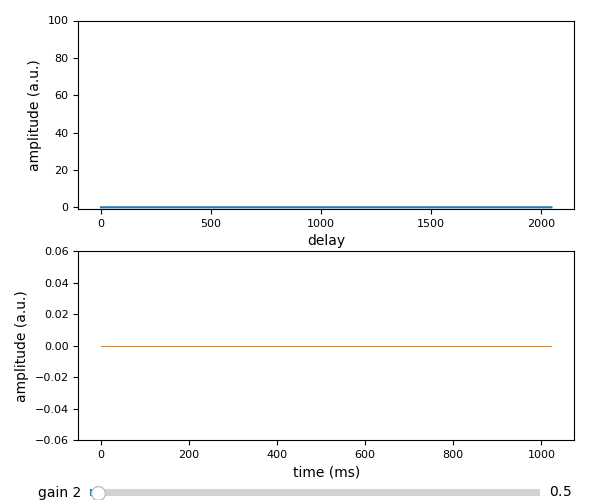

In [69]:
# Example 5: Phase-Locked-Loop
# SPDX-FileCopyrightText: Copyright (C) 2023 Andreas Naber <annappo@web.de>
# SPDX-License-Identifier: GPL-3.0-only

%matplotlib widget

import asyncio
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
from scipy.fft import fft, ifft
import gpslib
import linecache
import sys

# -------- floating point types used in arrays ---------

MY_FLOAT = np.float32
MY_COMPLEX = np.complex64

# --------- global variables ----------

MEAS_RUNNING = True             # global: if False, all processes are stopped
STATUS_MSG = ''                 # status message at program end
BUFFER = []                     # global data buffer for reading samples from 
                                # rtl-sdr
NBUF = 0                        # current size of buffer; see maxBufSize below 

SMP_TIME = 0                    # in units of 1/SAMPLE_RATE, ~0.5us, increased 
                                # after every sampling by NGPS; later used as 
                                # timestamp in data array
SAMPLE_RATE = 2.048E6           # number of samples (2 bytes) per second
N_CYC = 32                      # corresponds to 32 ms; bitrate is 50 bits/s, 
                                # thus 1 bit in 20 ms
CODE_SAMPLES = 2048             # interpolated points for C/A codes; 1 ms
NGPS = N_CYC*CODE_SAMPLES       # number of samples for each reading;
                                # power of 2 (for FFT)
CORR_AVG = 8                    # max is N_CYC 
DLF = 1024 // N_CYC             # factor for length of gpsPlotData (= 1024 ms)
MAXBUFSIZE = 8*NGPS             # max. size of sample buffer

SEC_TIME = np.linspace(1,NGPS,NGPS,endpoint=True)/SAMPLE_RATE   
                                # in s, for demodDoppler 

SWEEP_FACTOR = 16               # has to be set such that sweepFrequency needs 
                                # less than 32ms
MIN_FREQ = -5000.0
MAX_FREQ = +5000.0
STEP_FREQ = 200            
START_FREQ = MIN_FREQ
CORR_MIN = 8                    # required amplitude of correlation peak 
                                # (in units of standard deviations)
DF_GAIN1 = 10                   # feedback gains for PLL
DF_GAIN2 = 0.5
LOCKED_THRES = 0.3
OLD_PLL = True
    
DATA_FILE = '../data/data_140923_60s.bin'

SAT_LST = (24,19,12,15,13,17,22,25,23,10,32)

SAT_NO = 24

DF_LIST = []

# Precomputed FFT of interpolated cacode 
fftCacode = fft(gpslib.GPSCacode(SAT_NO,CODE_SAMPLES))


# ------- Exception handling & Output -------------------

EXC = ''

def printException():
    global EXC
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    EXC = ('EXCEPTION IN ({}, LINE {} "{}"): {}'\
           .format(filename, lineno, line.strip(), exc_obj))        
       
        
# -------- keyboard events ---------------

def onKeypress(event):
    global STATUS_MSG
    global MEAS_RUNNING
    sys.stdout.flush()
    if event.key in ['q','Q']:
        MEAS_RUNNING = False
        STATUS_MSG = 'q pressed'


# ------- data buffer -----------------

BUFSKIP = 0

def pushToBuffer(data):
    global BUFFER
    global NBUF
    global BUFSKIP
    
    if NBUF < MAXBUFSIZE:
        BUFSKIP = 0
        BUFFER += data
    else:
        BUFSKIP = NBUF
        BUFFER = data

    NBUF = len(BUFFER)

    
def pullFromBuffer(n):
    global BUFFER
    global NBUF
    global BUFSKIP
    
    if n > NBUF:
        n = NBUF        
    y = BUFFER[:n]
    BUFFER = BUFFER[n:]
    NBUF -= n

    return y,n,BUFSKIP
                
# --- Average data stream over gpsSamples = 1ms ("low-pass filter") -----

PREV_SAMPLES = []               # global: only used in following function

def decodeData(data,cp): 
    global PREV_SAMPLES
    
    gpscacode = gpslib.GPSCacodeRep(SAT_NO,CODE_SAMPLES,N_CYC,cp)             
    y = gpscacode*data                                     

    nps = len(PREV_SAMPLES)           
    if nps > 0:
        y = np.append(PREV_SAMPLES,y)
    ns = NGPS + nps 
    n0 = 0               
    n1 = nps + cp              # for first avg sometimes n1-n0 != 2048
    if n1 == 0:
        n1 = CODE_SAMPLES
        
    gpsData = []
    while n1 <= ns:
        m = np.mean(y[n0:n1])
        gpsData.append(m)
        n0 = n1
        n1 += CODE_SAMPLES
    gpsData = np.asarray(gpsData,dtype=MY_COMPLEX) 
    PREV_SAMPLES = y[n0:ns]

    return gpsData


# -------- find frequency correction ----------    

DF = [0]
DF_NO = 1024//N_CYC
maxDF = 20/(1024//N_CYC)
LOCKED = False

def phaseLockedLoop(gpsData):
    global DF
    global LOCKED
    avg = 4       
    minDiff = 2.0                               

    n = len(gpsData)                            
    phase = np.arctan(gpsData.imag/gpsData.real) 

    dp = 0
    realPhase = np.copy(phase)
    for i in range(1,n):              
        delta = phase[i]-phase[i-1]
        dp -= np.sign(delta) if abs(delta) > minDiff else 0            
        realPhase[i] += dp*np.pi

    phaseOffset = np.mean(realPhase[-avg:])                       

    if OLD_PLL:
        phaseDev = np.mean(realPhase)          
        if abs(phaseDev) < LOCKED_THRES:
            df = DF_GAIN2*phaseDev               
        else:
            df = DF_GAIN1*phaseDev        
    else:
        phaseDev = np.mean(realPhase)     
        if LOCKED:
            meanDF = np.mean(DF)
            fbDF = DF_GAIN2*phaseDev       
            df = fbDF + meanDF             
            if abs(df) > maxDF:
                df = np.sign(df)*maxDF
            if len(DF) >= DF_NO:
                del DF[0]
            DF.append(df)
        else:
            df = DF_GAIN1*phaseDev               
            DF = [df]
            
        if abs(phaseDev) < LOCKED_THRES:
            LOCKED = True
    
    return df, phaseOffset

            
# ------- Find maximum in correlation (delay) ---------

def findCodePhase(gpsCorr):
    mean = np.mean(gpsCorr)
    std = np.std(gpsCorr)
    delay = -1
    
    mx = np.argmax(gpsCorr)
    normMaxCorr = (gpsCorr[mx]-mean)/std
    if normMaxCorr > CORR_MIN:
        delay = int(mx)
             
    return delay,normMaxCorr

    
# ------ cross-correlation -------------

def correlation(data,avg): 
    avg = min(avg,N_CYC)
    df = 0
    for i in range(avg):
        dfm = fft(data[i*CODE_SAMPLES:(i+1)*CODE_SAMPLES])  
        df += dfm
    fftData = df/avg
    fftCorr = fftData*np.conjugate(fftCacode)   
    corr = np.abs(ifft(fftCorr))
    delay,normMaxCorr = findCodePhase(corr)
    return corr,delay,normMaxCorr


# ------  demodulation  -------------

def demodDoppler(data,freq,phase,N):                          
    factor = np.exp(-1.j*(phase+2*np.pi*freq*SEC_TIME[:N]))
    phase += 2*np.pi*freq*SEC_TIME[N-1]
    return factor*data[:N], np.remainder(phase,2*np.pi)


# ------- change doppler frequency within limits ---------
def confRange(freq):
    if freq > MAX_FREQ:
        freq -= MAX_FREQ - MIN_FREQ
    elif freq < MIN_FREQ:
        freq += MAX_FREQ - MIN_FREQ
    return freq

# -------- Sweep frequency -------------

def sweepFrequency(data,freq,n):
    delay = -1
    phase = 0
    k = 0
    N = CORR_AVG*CODE_SAMPLES    
    
    while delay<0 and k < n: 
        newdata,_ = demodDoppler(data,freq,phase,N)    
        gpsCorr,delay,normMaxCorr = correlation(newdata,CORR_AVG)
        if delay<0:
            freq = confRange(freq+STEP_FREQ)
        k += 1
    sweepFreq = (delay < 0)

    return sweepFreq, freq


# ------------- plot data -----------

def plotData(y1,y2):
    line1.set_ydata(y1.real)
    line2.set_ydata(y1.imag)
    line3.set_ydata(y2)
    plt.draw() 
    
# ------- process data -------------------

async def processData():   
    global MEAS_RUNNING
    global SMP_TIME
    global noStream

    gpsPlotData = np.zeros(DLF*N_CYC,dtype=MY_COMPLEX)   
    sweepAllFreq = True
    dopplerPhase = 0
    dopplerFreq = START_FREQ
    cp = 0
    noStream = 0
    try:
        while MEAS_RUNNING:
            if NBUF >= NGPS:
                data,n,skip = pullFromBuffer(NGPS)
                data = np.asarray(data,dtype=MY_COMPLEX)     
                SMP_TIME += NGPS + skip        

                if sweepAllFreq:
                    sweepAllFreq,dopplerFreq \
                        = sweepFrequency(data,dopplerFreq,SWEEP_FACTOR)
                else:    
                    data,dopplerPhase \
                        = demodDoppler(data,dopplerFreq,dopplerPhase,NGPS)    
                    gpsCorr,delay,normMaxCorr = correlation(data,CORR_AVG)               
                    if delay >= 0:
                        # integer codePhase only updated if correlation is 
                        # above threshold                        
                        cp = delay        
                    gpsData = decodeData(data,cp)

                    gpsPlotData = np.concatenate(\
                                  (gpsPlotData[N_CYC:DLF*N_CYC],gpsData))                
                    if noStream % DLF == 0:                  # ~ 1 second
                        plotData(gpsPlotData,gpsCorr)                          

                    deltaFreq,phaseOffset = phaseLockedLoop(gpsData)
                    dopplerPhase += phaseOffset
                    dopplerFreq  += deltaFreq       

                    DF_LIST.append(-dopplerFreq)
                                    
                noStream += 1
                    
            await asyncio.sleep(0)
        
    except BaseException:
        printException()
    finally:            
        MEAS_RUNNING = False

        
# ----------- Streaming ----------------        
            
async def streamData():
    global MEAS_RUNNING
    global STATUS_MSG
    try:
        with open(DATA_FILE,'rb') as f1:
            while MEAS_RUNNING:
                if NBUF < NGPS:
                    byteData = np.fromfile(f1,dtype=np.uint16,count=NGPS)
                    im,re = np.divmod(byteData,256)
                    samples = np.asarray(re+1j*im,dtype=np.complex64)/127.5\
                              - (1+1j)
                    if len(samples)>0:
                        pushToBuffer(list(samples))
                    else:
                        MEAS_RUNNING = False
                        STATUS_MSG = 'EOF'
                await asyncio.sleep(0)
    except BaseException as err:
        STATUS_MSG = err
        printException()
    finally:
        MEAS_RUNNING = False                    

# --------------- code for plots ------------------        

# initial values for plot data (real and imag)
xd = np.linspace(0, DLF*N_CYC, DLF*N_CYC, endpoint=False)  # in ms
yd = np.zeros(DLF*N_CYC,dtype=MY_COMPLEX)   # global

# initial values for correlation plot
xc = np.linspace(0.0, CODE_SAMPLES, CODE_SAMPLES, endpoint=False)
yc = np.zeros(CODE_SAMPLES)

fig = plt.figure(figsize=(6,5))
fig.canvas.header_visible = False      # hide header
fig.canvas.mpl_connect('key_press_event', onKeypress)   

fig.subplots(2,1)

plt.subplot(2,1,2)
line1, = plt.plot(xd,yd.real,lw=.5)
line2, = plt.plot(xd,yd.imag,lw=.5)
plt.ylim(-0.06,0.06)
plt.xlabel('time (ms)', fontsize=10)
plt.ylabel('amplitude (a.u.)', fontsize=10) 
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)    
plt.tight_layout()             # prevents cutting of xlabel
    
plt.subplot(2,1,1)
line3, = plt.plot(xc,yc) 
plt.ylim(-1,100)
plt.xlabel('delay', fontsize=10)
plt.ylabel('amplitude (a.u.)', fontsize=10) 
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)    

fig.subplots_adjust(bottom=0.12)

axGain2 = fig.add_axes([0.15, 0.0, 0.75, 0.03])
gain2_slider = Slider(
    ax=axGain2,
    label='gain 2',
    valmin=0,
    valmax=30,
    valstep=0.1,
    valinit=DF_GAIN2,
)

# The function to be called anytime a slider's value changes
def update(val):
    global DF_GAIN2
    DF_GAIN2 = gain2_slider.val

gain2_slider.on_changed(update)

# --- asyncio tasks -------------

loop = asyncio.get_event_loop()
task1 = loop.create_task(processData())
task3 = loop.create_task(streamData())

print('Click on graph and press q to exit!')
        


In [ ]:
EXC

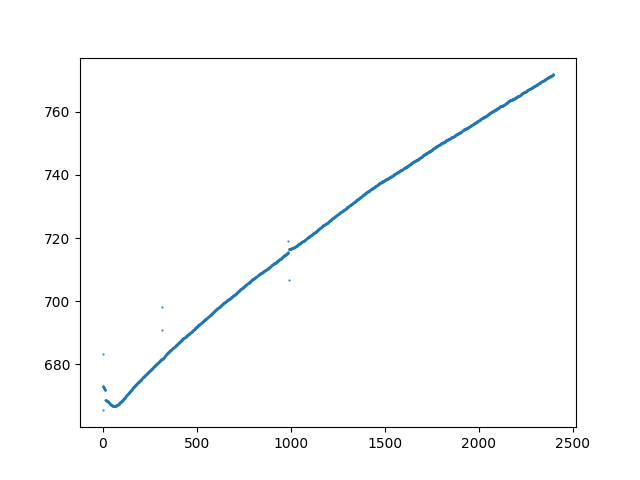

In [70]:
fig,ax = plt.subplots()

plt.plot(DF_LIST,'o',ms=.5)

plt.show()

In [71]:
df_2=DF_LIST.copy()

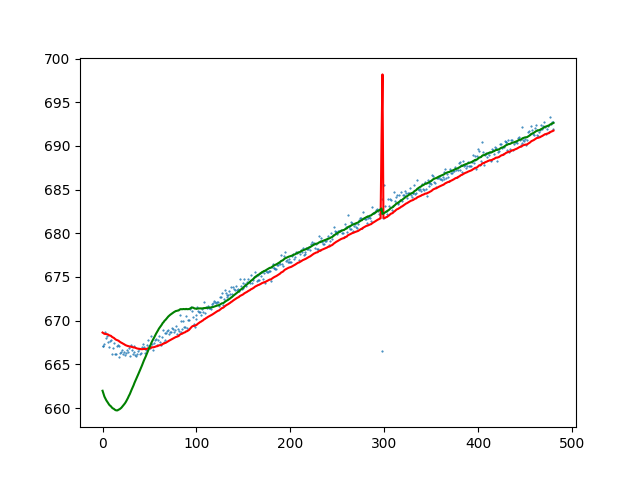

In [73]:
fig,ax = plt.subplots()

N = 500
S = 19

plt.plot(df_1[S:N],'o',ms=.5)
plt.plot(df_2[S:N],'r',ms=.5)
plt.plot(df_3[S:N],'g',ms=.5)

plt.show()